# CS5340 Lecture 2:  MLE, MAP and Bayesian Methods#
by Harold Soh (harold@comp.nus.edu.sg)

Graduate TAs: Abdul Fatir Ansari and Chen Kaiqi (AY19/20)

This notebook is a supplement to Lecture 2 of CS5340: Uncertainty Modeling in AI


In [494]:
%matplotlib inline

import numpy as np
from scipy import optimize

from numpy.random import randn
from numpy import log, exp

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import scipy.stats as stats
import scipy.special
from  scipy.special import gamma as gammaf

# Create some data from our simulated ranger #

In [541]:
#create some data (this is our simulated sensor)
N = 3
r = 1 # our object is 1m away
np.random.seed(0)

# true parameters
mu_true = 0.1
var_true = 0.05

# some noise 
x = np.sqrt(var_true)*np.random.randn(N,1) + mu_true

# our model
y =  r + x


(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([1.18947787, 1.20980962, 1.23014137, 1.25047312, 1.27080487,
        1.29113661, 1.31146836, 1.33180011, 1.35213186, 1.37246361,
        1.39279535, 1.4131271 , 1.43345885, 1.4537906 , 1.47412235,
        1.4944541 ]),
 <a list of 15 Patch objects>)

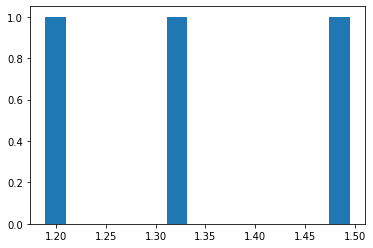

In [542]:
plt.hist(y, 15)

# Learning the Parameters #
In this section, we'll use the theory learnt in lecture (MLE, Bayesian, and MAP) to learn the parameters of the model.

## Maximum Likelihood Estimation (MLE) ##
First, we'll derive the maximum likelihood estimates for $\mu$ and $\sigma^2$ using the closed-form equations developed in class.

In [543]:
# MLE estimate
# closed form
mu_MLE = np.mean(x)
var_MLE = np.mean( (x)**2 ) - (mu_MLE)**2

In [544]:
print("mu_MLE = %g, var_MLE = %g"%(mu_MLE, var_MLE))

mu_MLE = 0.334261, var_MLE = 0.0156205


Let's try using an off-the-shelf optimizer to numerically *minimize* the *negative* log-likehood directly (equivalent to *maximizing* the log likelihood). It should give us the same answer (or something really close)

In [545]:
# using an optimizer
def negloglike(theta, x):
    mu = theta[0]
    var = exp(theta[1])
    N = x.size
    nll = N*log(var) + np.sum((x - mu)**2/var)
    return nll

In [546]:
params = optimize.minimize(negloglike, np.array([1, 2]), args=(x), method='BFGS')

In [547]:
print(params)

mu_MLEopt = params.x[0]
var_MLEopt = exp(params.x[1])

print("--------------------------------------------------------")
print("mu_MLEopt = %g, var_MLEopt = %g"%(mu_MLEopt, var_MLEopt))

      fun: -9.47751944841201
 hess_inv: array([[2.39793045e-03, 1.91961167e-04],
       [1.91961167e-04, 3.33001854e-01]])
      jac: array([-1.43051147e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 76
      nit: 11
     njev: 19
   status: 0
  success: True
        x: array([ 0.33426147, -4.15917314])
--------------------------------------------------------
mu_MLEopt = 0.334261, var_MLEopt = 0.0156205


We can plot $p(D|\mu, \sigma^2)$ and examine where the MLE is.

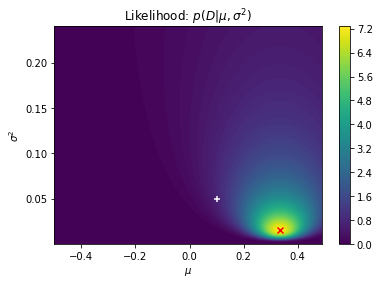

In [548]:
d = 0.01
mp = np.arange(-0.5, 0.5, d)
sp = np.arange(0.01, 0.5, d) #standard deviation
Mp, Sp = np.meshgrid(mp, sp)
Zlike = np.zeros(Mp.shape)
for i in range(Mp.shape[0]):
    for j in range(Mp.shape[1]):
        Zlike[i,j] = exp(np.sum(stats.norm.logpdf(x, loc=Mp[i,j], scale=Sp[i,j])))

def plotDist(M, S, Z, title):
    fig, ax = plt.subplots()
    CS = ax.contourf(M, S**2, Z, 100)
    #ax.clabel(CS, inline=1, fontsize=10)
    ax.set_title(title)
    fig.colorbar(CS, ax=ax)
    ax.set_xlabel('$\mu$')
    ax.set_ylabel('$\sigma^2$')
    return (fig,ax)

plotDist(Mp, Sp, Zlike, 'Likelihood: $p(D|\mu, \sigma^2)$')
plt.scatter(mu_true, var_true, marker='+', color='w')
plt.scatter(mu_MLE, var_MLE, marker='x', color="r")


# Bayesian Approach #
Next, let's try full Bayesian posterior estimation. First, we define the parameters of our prior (a NormalInverseGamma[$\delta, \gamma, \alpha, \beta$]) and plot the prior to get an idea of how it looks like

In [549]:
# Prior parameters
delta = 0.0 # mean
gamma = 3.0

# put mode of variance at 0.05 
alpha = 1.01
beta = var_true*(alpha + 1.5)

mode = beta/(alpha + 1.5)
print("Variance Mode: %g"%(mode))

Variance Mode: 0.05


In [550]:
# plot the prior
Zp = np.zeros(Mp.shape)
for i in range(Mp.shape[0]):
    for j in range(Mp.shape[1]):
        Zp[i,j] = exp(
            stats.norm.logpdf(Mp[i,j], loc=delta, scale=Sp[i,j]/np.sqrt(gamma)) +
            stats.invgamma.logpdf(Sp[i,j]**2, alpha, scale=beta)
        )


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a30e51790>)

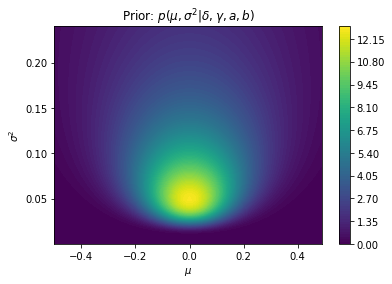

In [551]:
plotDist(Mp, Sp, Zp, 'Prior: $p(\mu, \sigma^2|\delta,\gamma,a,b)$')

Let's plot the *unnormalized posterior* to take a look (this is the numerator $p(D|\mu, \sigma^2)p(\mu, \sigma^2|\delta,\gamma,a,b)$ of the RHS of the Bayes update rule, i.e., before normalizing with $p(D)$).

In [552]:
Znum = np.zeros(Mp.shape)
for i in range(Mp.shape[0]):
    for j in range(Mp.shape[1]):
        Znum[i,j] = exp(
            np.sum(stats.norm.logpdf(x, loc=Mp[i,j], scale=Sp[i,j])) +
            stats.norm.logpdf(Mp[i,j], loc=delta, scale=Sp[i,j]/np.sqrt(gamma)) +
            stats.invgamma.logpdf(Sp[i,j]**2, alpha, scale=beta)
        )


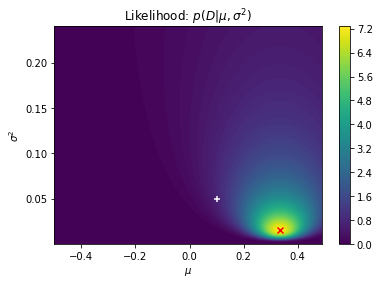

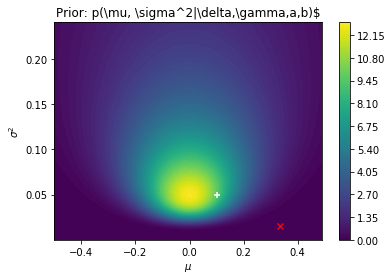

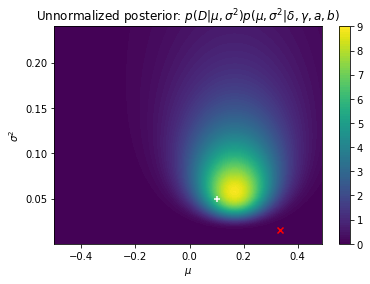

In [553]:
plotDist(Mp, Sp, Zlike, 'Likelihood: $p(D|\mu, \sigma^2)$')
plt.scatter(mu_true, var_true, marker='+', color='w')
plt.scatter(mu_MLE, var_MLE, marker='x', color="r")

plotDist(Mp, Sp, Zp, 'Prior: p(\mu, \sigma^2|\delta,\gamma,a,b)$')
plt.scatter(mu_true, var_true, marker='+', color='w')
plt.scatter(mu_MLE, var_MLE, marker='x', color="r")

plotDist(Mp, Sp, Znum, 'Unnormalized posterior: $p(D|\mu, \sigma^2)p(\mu, \sigma^2|\delta,\gamma,a,b)$')
plt.scatter(mu_true, var_true, marker='+', color='w')
plt.scatter(mu_MLE, var_MLE, marker='x', color="r")


We can update the posterior in closed form as described in the lecture

In [554]:
xbar = np.mean(x)

delta_post = (delta*gamma + N*xbar)/(gamma + N) # mean
gamma_post = gamma + N
alpha_post = alpha + N/2
beta_post = beta + np.sum( (x- xbar)**2)/2 + ((gamma*N)/(gamma + N))*(((xbar - delta)**2)/2)

In [555]:

print("Priors:\n delta = %g\n gamma = %g\n alpha = %g\n beta = %g\n"%(delta, gamma, alpha, beta))
print("Posteriors:\n delta = %g\n gamma = %g\n alpha = %g\n beta = %g\n"%(delta_post, gamma_post, alpha_post, beta_post))

Priors:
 delta = 0
 gamma = 3
 alpha = 1.01
 beta = 0.1255

Posteriors:
 delta = 0.167131
 gamma = 6
 alpha = 2.51
 beta = 0.232729



Let's plot this posterior

In [556]:
Zpost = np.zeros(Mp.shape)
for i in range(Mp.shape[0]):
    for j in range(Mp.shape[1]):
        Zpost[i,j] = exp(
            stats.norm.logpdf(Mp[i,j], loc=delta_post, scale=Sp[i,j]/np.sqrt(gamma_post)) +
            stats.invgamma.logpdf(Sp[i,j]**2, alpha_post, scale=beta_post)
        )


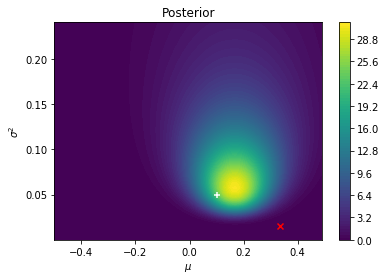

In [557]:
plotDist(Mp, Sp, Zpost, 'Posterior')
plt.scatter(mu_true, var_true, marker='+', color='w')
plt.scatter(mu_MLE, var_MLE, marker='x', color="r")


## Maximum a Posteriori (MAP) Estimation ##
Finally, let's try MAP estimation which is a "middle ground" approach

In [558]:
# closed form
mu_MAP = (N*np.mean(x) + gamma*delta)/(N+gamma)  
var_MAP = (np.sum((x - mu_MAP)**2) + 2*beta + gamma*(delta - mu_MAP)**2)/(N + 3 + 2*alpha)

In [559]:
print("mu_MAP = %g, var_MAP = %g"%(mu_MAP, var_MAP))

mu_MAP = 0.167131, var_MAP = 0.0580371


Again, we use an optimizer which should give us very similar results to the above

In [560]:
# using an optimizer
def neglogpost(theta, x):
    mu = theta[0]
    var = exp(theta[1])
    N = x.size
    nlpost = (log(var)*(N+ (2*alpha) + 3)/2) + ((np.sum((x - mu)**2) +  2*beta + (gamma*(delta - mu)**2))/(2*var))
    return nlpost

In [561]:
neglogpost([mu_MAP, log(var_MAP)], x)

-7.405158285012733

In [562]:
params = optimize.minimize(neglogpost, np.array([1, 2.0]), args=(x), 
                           method='BFGS'
                          )

In [563]:
print(params)

mu_MAPopt = params.x[0]
var_MAPopt = exp(params.x[1])

print("mu_MAPopt = %g, var_MAPopt = %g"%(mu_MAPopt, var_MAPopt))

      fun: -7.40515828501273
 hess_inv: array([[9.58322855e-03, 6.53269680e-05],
       [6.53269680e-05, 2.49293098e-01]])
      jac: array([ 1.43051147e-06, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 52
      nit: 7
     njev: 13
   status: 0
  success: True
        x: array([ 0.16713075, -2.8466729 ])
mu_MAPopt = 0.167131, var_MAPopt = 0.0580371


We can also plot the MAP estimate to see where it falls relative to the MLE and Bayesian posterior.

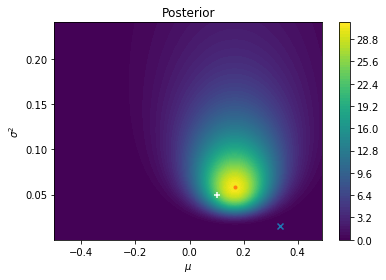

In [564]:

plotDist(Mp, Sp, Zpost, 'Posterior')
plt.scatter(mu_MLE, var_MLE, marker='x')
plt.scatter(mu_MAP, var_MAP, marker='.')
plt.scatter(mu_true, var_true, marker='+', color='w')


# Making Predictions #

Suppose there is a obstable 2.0m away from our sensor. Since our sensor is imperfect, it returns some reading $\hat{y} = r + x$ where $x$ is drawn from $N(\mu, \sigma^2)$. Let us estimate the real distance of this obstacle based on our earlier computed parameters and this observation.


In [565]:
r_true = 2.0 # you can change this
X = scipy.stats.norm(loc=mu_true, scale=np.sqrt(var_true))
yhat = r_true + X.rvs(1)
print(yhat)

[2.60107895]


## MLE and MAP Predictions##
Recall that $X \sim N(\mu, \sigma^2)$. Let the range to the obstacle $R = \hat{y} - X$. R is also normally-distributed, $R \sim N(\hat{y} - \mu, \sigma^2)$. 

In [566]:
# closed form
r_MLE = yhat - mu_MLE
r_MAP = yhat - mu_MAP

print(" r_MLE = %g \n r_MAP = %g"%(r_MLE, r_MAP))


 r_MLE = 2.26682 
 r_MAP = 2.43395


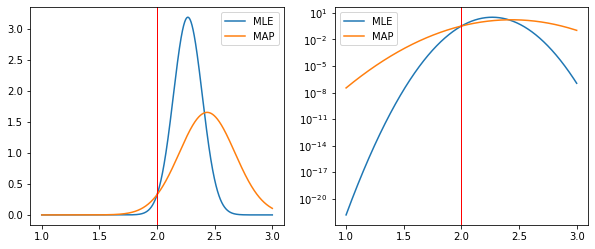

In [567]:
z = np.arange(1.0, 3, 0.001)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(z, stats.norm.pdf(z, loc=r_MLE, scale=np.sqrt(var_MLE)), label="MLE")
ax[0].plot(z, stats.norm.pdf(z, loc=r_MAP, scale=np.sqrt(var_MAP)), label="MAP")
ax[0].axvline(x=r_true, color='red', lw=1)
ax[0].legend()

ax[1].semilogy(z, stats.norm.pdf(z, loc=r_MLE, scale=np.sqrt(var_MLE)), label="MLE")
ax[1].semilogy(z, stats.norm.pdf(z, loc=r_MAP, scale=np.sqrt(var_MAP)), label="MAP")
ax[1].axvline(x=r_true, color='red', lw=1)
ax[1].legend()

## Bayesian Predictions ##
The posterior predictive is actually a generalized Student-t distribution. See Sections 3 and 6 of Kevin Murphy's monograph on Conjugate Bayesian analysis of the Gaussian Distribution (https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf)

Given our model, $R$ is also Student-t distributed but with location parameter $\hat{y} - \mu_T$ where $\mu_T$ is the location parameter of our Student-T

In [568]:
yhat

array([2.60107895])

In [569]:
def tpdf(x, delta, gamma, alpha, beta):

    prec = (alpha*gamma)/(beta*(gamma+1))
    doft = alpha + 0.5
    
    p = np.sqrt( (prec / (2*alpha*np.pi) ) )*(gammaf(doft)/gammaf(alpha))*(np.array(1+ (prec*(x - delta)**2 )/(2*alpha) )**(-doft))

    return p
    

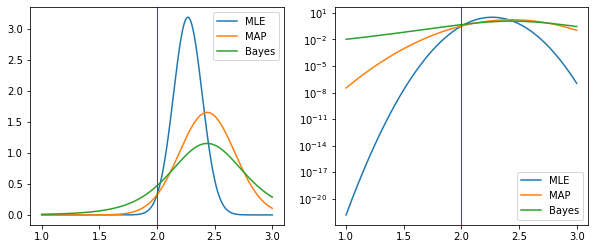

In [570]:
z = np.arange(1.0, 3.0, 0.001)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(z, stats.norm.pdf(z, loc=r_MLE, scale=np.sqrt(var_MLE)), label="MLE")
ax[0].plot(z, stats.norm.pdf(z, loc=r_MAP, scale=np.sqrt(var_MAP)), label="MAP")
ax[0].plot(z, tpdf(z,yhat - delta_post,gamma_post, alpha_post , beta_post), label="Bayes")

ax[0].axvline(x=r_true, color='red', lw=1)
ax[0].legend()

ax[1].semilogy(z, stats.norm.pdf(z, loc=r_MLE, scale=np.sqrt(var_MLE)), label="MLE")
ax[1].semilogy(z, stats.norm.pdf(z, loc=r_MAP, scale=np.sqrt(var_MAP)), label="MAP")
ax[1].semilogy(z, tpdf(z,yhat - delta_post,gamma_post, alpha_post , beta_post), label="Bayes")

ax[1].axvline(x=r_true, color='red', lw=1)
ax[1].legend()


If you have set a low number of observations (e.g., $N = 3$), you'll likely see  MAP would typically be overconfident relative to the Bayes estimate (given a broad prior). If you selected a high number of observations, say $N=300$, the estimates should match to a good degree.

### Comparing MAP and MLE via MSE ###

Let's quantify the errors made by both models

In [604]:
X = scipy.stats.norm(loc=mu_true, scale=np.sqrt(var_true))
yhat = r_true + X.rvs(100000)
r_MLE = yhat - mu_MLE
r_MAP = yhat - mu_MAP

# calculate the MSE
err_MLE = np.mean( (r_true - r_MLE  )**2)
err_MAP = np.mean( (r_true - r_MAP  )**2)

print(" Error_MLE = %g \n Error_MAP = %g"%(err_MLE, err_MAP))



 Error_MLE = 0.104813 
 Error_MAP = 0.0544
